In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [35]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
sample_submission_df = pd.read_csv('/content/sample_submission.csv')

In [36]:
import pandas as pd
df = pd.read_csv('/content/sample_submission.csv')
df = pd.read_csv('/content/test.csv')
df = pd.read_csv('/content/train.csv')

In [37]:
# Display initial information
print("Initial train dataset info:")
train_df.info()
print("\nInitial test dataset info:")
test_df.info()

Initial train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB

Initial test dat

In [38]:
# Fill NaN values
train_df['Item_Weight'].fillna(train_df['Item_Weight'].mean(), inplace=True)
test_df['Item_Weight'].fillna(test_df['Item_Weight'].mean(), inplace=True)
train_df['Outlet_Size'].fillna(train_df['Outlet_Size'].mode()[0], inplace=True)
test_df['Outlet_Size'].fillna(test_df['Outlet_Size'].mode()[0], inplace=True)

In [39]:
# Handle outliers using IQR
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound,
    np.where(df[column] < lower_bound, lower_bound, df[column]))

In [40]:
numerical_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']
for column in numerical_columns:
    handle_outliers(train_df, column)
    if column != 'Item_Outlet_Sales':
        handle_outliers(test_df, column)

In [41]:
# Encode categorical features
le = LabelEncoder()
cat_col = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

for col in cat_col:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# Ensure there are no unexpected string values in numerical columns
for col in numerical_columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    if col != 'Item_Outlet_Sales':
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

In [42]:
# Drop the 'Item_Identifier' column as it's not useful for prediction
train_df.drop(columns=['Item_Identifier'], inplace=True)
test_df.drop(columns=['Item_Identifier'], inplace=True)

# Check for any remaining missing values after conversion
print("\nTrain dataset NaN values after numeric conversion:")
print(train_df.isnull().sum())
print("\nTest dataset NaN values after numeric conversion:")
print(test_df.isnull().sum())


Train dataset NaN values after numeric conversion:
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Test dataset NaN values after numeric conversion:
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64


<ipython-input-43-5c47c9387bbd>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[column])


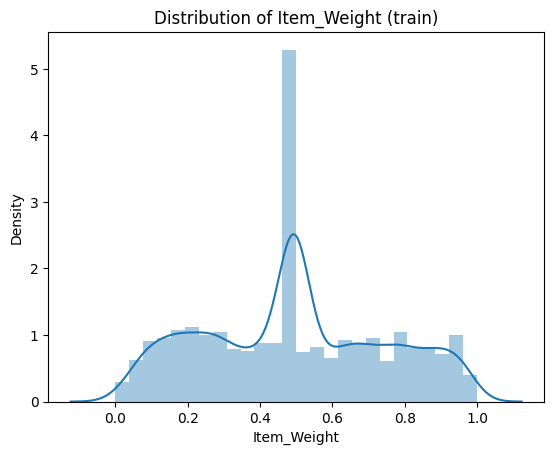

<ipython-input-43-5c47c9387bbd>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[column])


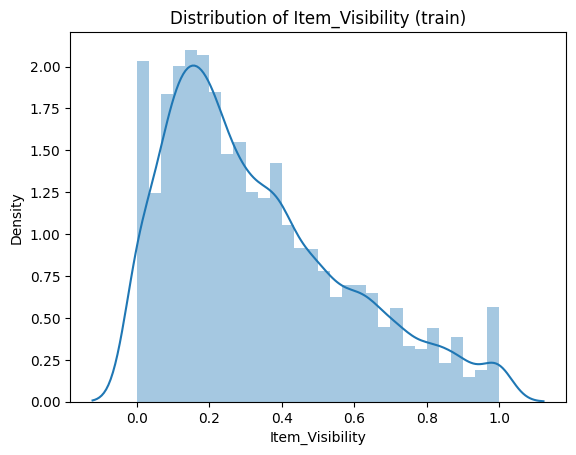

<ipython-input-43-5c47c9387bbd>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[column])


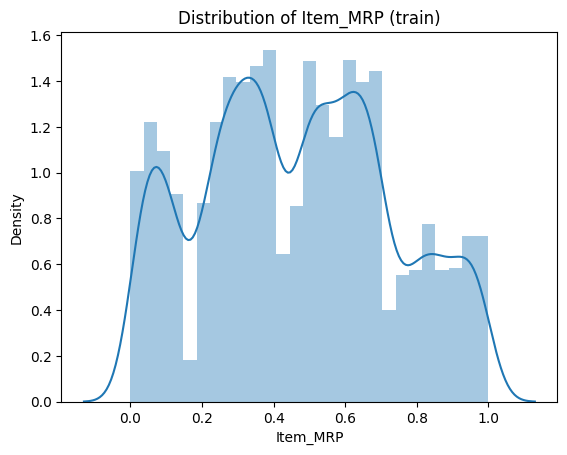

<ipython-input-43-5c47c9387bbd>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[column])


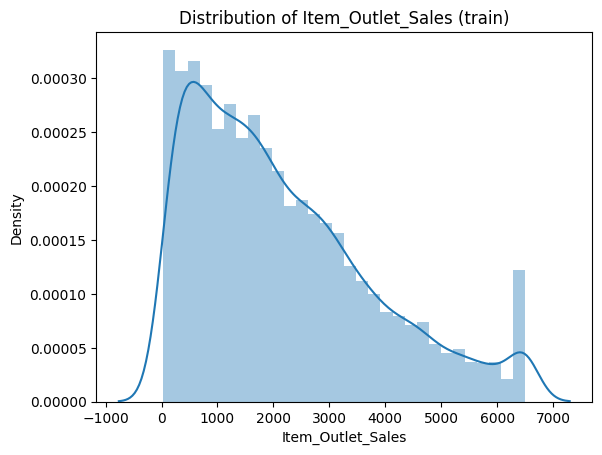

<ipython-input-43-5c47c9387bbd>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_df[column])


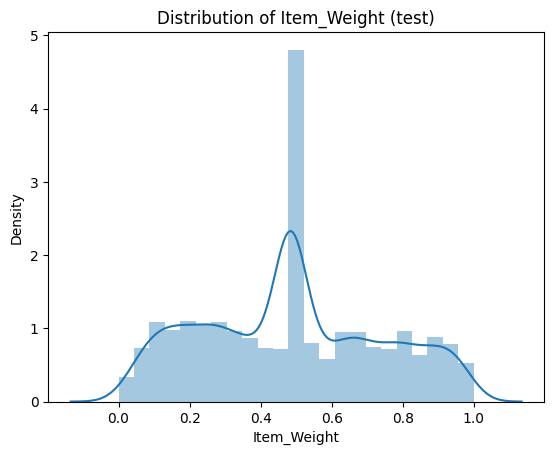

<ipython-input-43-5c47c9387bbd>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_df[column])


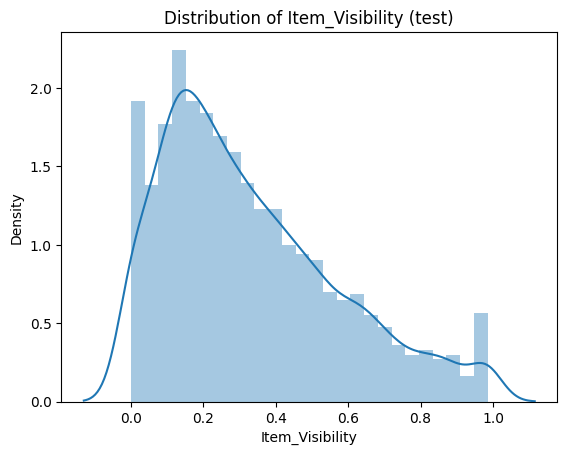

<ipython-input-43-5c47c9387bbd>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_df[column])


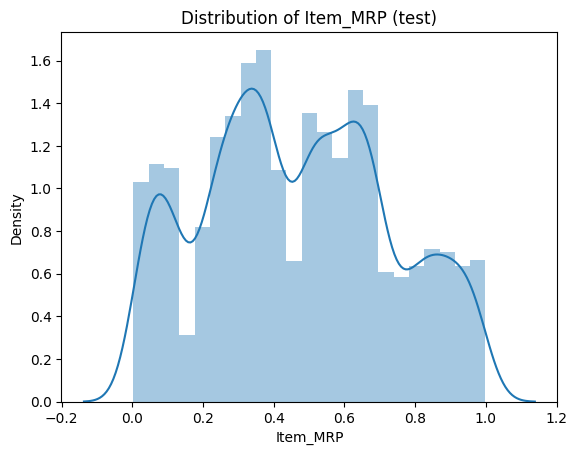

In [43]:
# Scale numerical features
scaler = MinMaxScaler()

# Check if 'Item_Outlet_Sales' is in the list before removing
if 'Item_Outlet_Sales' in numerical_columns:
    numerical_columns.remove('Item_Outlet_Sales')  # Remove target variable from scaling

# Assuming 'train_df' and 'test_df' contain the features
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

# Display distribution plots for cleaned numerical columns in the TRAINING set
for column in numerical_columns + ['Item_Outlet_Sales']:
    sns.distplot(train_df[column])
    plt.title(f'Distribution of {column} (train)')
    plt.show()

# Display distribution plots for cleaned numerical columns in the TEST set
for column in numerical_columns:
    sns.distplot(test_df[column])
    plt.title(f'Distribution of {column} (test)')
    plt.show()

<Axes: >

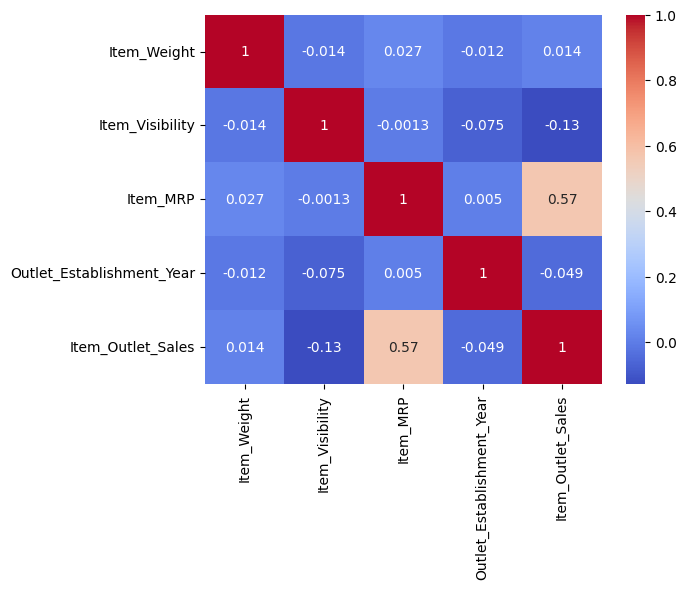

In [44]:
# Calculate correlations only on numeric columns
numeric_df = df.select_dtypes(include=['float', 'int'])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [45]:
# Train-test split
X = train_df.drop(columns=['Item_Outlet_Sales'])
y = train_df['Item_Outlet_Sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

In [46]:
# Define cross-validation function
def cross_validation(model, X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    results = cross_val_score(model, X, y, cv=kf, scoring='r2')
    return results.mean() * 100, results.std() * 100

# Hyperparameter tuning
def tune_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [47]:
# Random Forest
rf_reg = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 50],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 5]
}
rf_best = tune_model(rf_reg, param_grid_rf, X_train, y_train)
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_val)
r2_rf = r2_score(y_val, y_pred_rf)
print(f"Random Forest R2 Score: {r2_rf}")
accuracy_rf, std_rf = cross_validation(rf_best, X, y)
print(f"Random Forest CV Accuracy: {accuracy_rf}, Std Dev: {std_rf}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Random Forest R2 Score: 0.6106089328425777
Random Forest CV Accuracy: 60.47146930542191, Std Dev: 2.1552938592361826


In [48]:
# Gradient Boosting
gb_reg = GradientBoostingRegressor(random_state=42)
param_grid_gb = {
    'n_estimators': [50, 50],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 5]
}
gb_best = tune_model(gb_reg, param_grid_gb, X_train, y_train)
gb_best.fit(X_train, y_train)
y_pred_gb = gb_best.predict(X_val)
r2_gb = r2_score(y_val, y_pred_gb)
print(f"Gradient Boosting R2 Score: {r2_gb}")
accuracy_gb, std_gb = cross_validation(gb_best, X, y)
print(f"Gradient Boosting CV Accuracy: {accuracy_gb}, Std Dev: {std_gb}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Gradient Boosting R2 Score: 0.6156133771474779
Gradient Boosting CV Accuracy: 60.98557906564157, Std Dev: 2.146523330344099


In [49]:
# XGBoost
xgb_reg = XGBRegressor(random_state=42)
param_grid_xgb = {
    'n_estimators': [50, 50],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 5]
}
xgb_best = tune_model(xgb_reg, param_grid_xgb, X_train, y_train)
xgb_best.fit(X_train, y_train)
y_pred_xgb = xgb_best.predict(X_val)
r2_xgb = r2_score(y_val, y_pred_xgb)
print(f"XGBoost R2 Score: {r2_xgb}")
accuracy_xgb, std_xgb = cross_validation(xgb_best, X, y)
print(f"XGBoost CV Accuracy: {accuracy_xgb}, Std Dev: {std_xgb}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
XGBoost R2 Score: 0.6178678563049151
XGBoost CV Accuracy: 61.11836060709568, Std Dev: 2.1513370782749726


In [50]:
# Make predictions on the test set using the best model (based on performance)
final_model = xgb_best  # or rf_best, gb_best, based on performance
test_predictions = final_model.predict(test_df)

# Prepare submission file
sample_submission_df['Item_Outlet_Sales'] = test_predictions
sample_submission_df.to_csv('submission.csv', index=False)
print("Submission file created successfully.")

# Linear Regression for comparison
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
y_pred_lr = lr_reg.predict(X_val)
r2_lr = r2_score(y_val, y_pred_lr)
print(f"Linear Regression R2 Score: {r2_lr}")

# Make predictions on the test set using the Linear Regression model
test_predictions_lr = lr_reg.predict(test_df)

Submission file created successfully.
Linear Regression R2 Score: 0.522733193779763


In [51]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calculate evaluation metrics for Random Forest model
mse_rf = mean_squared_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

# Print evaluation metrics
print(f"Random Forest Evaluation Metrics:")
print(f"R2 Score: {r2_rf}")
print(f"Mean Squared Error: {mse_rf}")
print(f"Root Mean Squared Error: {rmse_rf}")
print(f"Mean Absolute Error: {mae_rf}")

# Repeat the process for other models as needed

Random Forest Evaluation Metrics:
R2 Score: 0.6106089328425777
Mean Squared Error: 994809.9092800806
Root Mean Squared Error: 997.4015787435272
Mean Absolute Error: 722.2194243229336


In [52]:
# XGBoost metrics
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
r2_xgb = r2_score(y_val, y_pred_xgb)

# Print evaluation metrics for all models
print("\nModel Evaluation Metrics:")

print("\nRandom Forest:")
print(f"R2 Score: {r2_rf}")
print(f"Mean Squared Error: {mse_rf}")
print(f"Root Mean Squared Error: {rmse_rf}")
print(f"Mean Absolute Error: {mae_rf}")

print("\nXGBoost:")
print(f"R2 Score: {r2_xgb}")
print(f"Mean Squared Error: {mse_xgb}")
print(f"Root Mean Squared Error: {rmse_xgb}")
print(f"Mean Absolute Error: {mae_xgb}")


Model Evaluation Metrics:

Random Forest:
R2 Score: 0.6106089328425777
Mean Squared Error: 994809.9092800806
Root Mean Squared Error: 997.4015787435272
Mean Absolute Error: 722.2194243229336

XGBoost:
R2 Score: 0.6178678563049151
Mean Squared Error: 976264.930722266
Root Mean Squared Error: 988.0611978628986
Mean Absolute Error: 715.1640172767652


Confusion Matrix:
[[1279   20  202]
 [ 104  794  144]
 [ 396  137  334]]


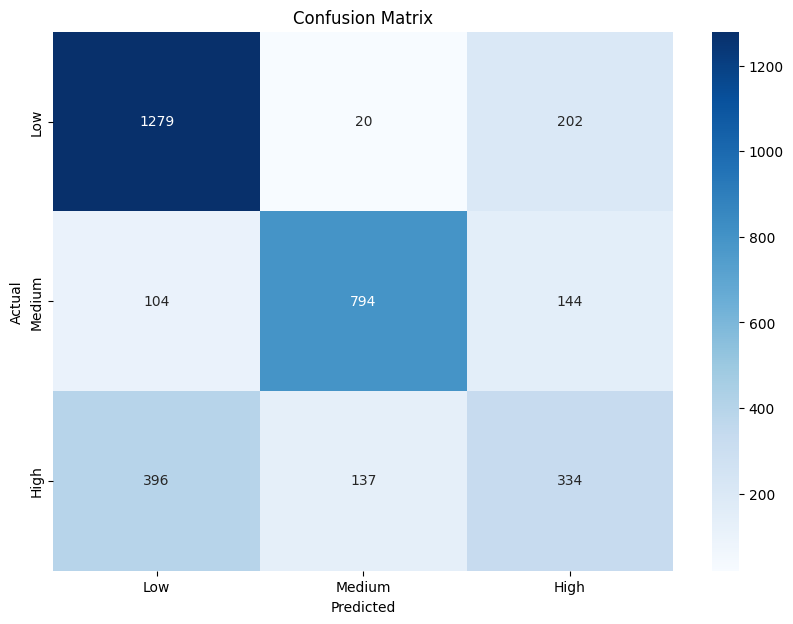

Classification Report:
              precision    recall  f1-score   support

        High       0.72      0.85      0.78      1501
         Low       0.83      0.76      0.80      1042
      Medium       0.49      0.39      0.43       867

    accuracy                           0.71      3410
   macro avg       0.68      0.67      0.67      3410
weighted avg       0.70      0.71      0.70      3410



In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Convert regression target to classification target (example: Low, Medium, High sales)
bins = [0, 1000, 2000, np.inf]
labels = ['Low', 'Medium', 'High']
train_df['Sales_Category'] = pd.cut(train_df['Item_Outlet_Sales'], bins=bins, labels=labels)

# Define your features and the new classification target
X_class = train_df.drop(columns=['Item_Outlet_Sales', 'Sales_Category'])
y_class = train_df['Sales_Category']

# Train-test split for classification
X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(X_class, y_class, test_size=0.4, random_state=42)

# Train a Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_class, y_train_class)

# Make predictions
y_pred_class = rf_clf.predict(X_val_class)

# Confusion Matrix
cm = confusion_matrix(y_val_class, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val_class, y_pred_class))

In [55]:
import joblib

# Replace 'final_model' with the variable name of the model you want to save
# For example, if you want to save the XGBoost model:
model_to_save = xgb_best
classifier = joblib.dump(model_to_save, 'model.pkl')